# Vision Transformers (ViT) y capa densa para regresión


In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('data/data.csv')

In [3]:
dataset = dataset.sample(frac=0.5, random_state=42)
len(dataset)

13034

## Preparación y limpieza de datos

In [4]:
numeric_features = ['extent']
categorical_features = ['growth_stage', 'damage', 'season']

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

transformers_encoder_onehot = [
    ('encoder', OneHotEncoder(), categorical_features)
]
column_transformer = ColumnTransformer(transformers_encoder_onehot, remainder='passthrough')


dataset_encoded = column_transformer.fit_transform(dataset)
dataset = pd.DataFrame(dataset_encoded, columns=column_transformer.get_feature_names_out())


new_column_names = [col.replace('encoder__', '').replace('remainder__', '') for col in column_transformer.get_feature_names_out()]
dataset.columns = new_column_names

In [6]:
dataset = dataset.drop(columns=['ID'])

In [7]:
dataset

,growth_stage_F,growth_stage_M,growth_stage_S,growth_stage_V,damage_DR,damage_DS,damage_FD,damage_G,damage_ND,damage_PS,damage_WD,damage_WN,season_LR2020,season_LR2021,season_SR2020,season_SR2021,filename,extent
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,L1089F02141C39S11798Rp37726.jpg,30
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,L1094F04274C01S08980Rp16999.jpg,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,L371F01082C39S12783Rp47190.jpg,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,L378F00117C39S12219Rp44858.jpg,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,L141F03044C39S14008Rp35145.jpg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13029,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,L222F00239C39S14292Rp39595.jpg,0
13030,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,L406F00266C01S08380Rp20339.jpg,0
13031,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,L1132F04290C39S12090Rp33475.jpg,0
13032,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,L141F01836C39S12521Rp46000.jpg,20


In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(dataset, test_size=0.2, random_state=42)

## Modelo

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import zipfile
import os

# Ruta del archivo ZIP y de la carpeta de destino
zip_file_path = '/content/drive/MyDrive/train.zip'
destination_folder = 'data/train'

# Crear la carpeta de destino si no existe
os.makedirs(destination_folder, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Archivo descomprimido en: {destination_folder}")


Archivo descomprimido en: data/train


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import pandas as pd
from pathlib import Path

# Constantes para el modelo
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 8
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [256, 128]
BATCH_SIZE = 32

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_dir, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.dataframe = dataframe.copy()
        self.image_dir = Path(image_dir)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataframe))

        # Convertir columnas categóricas a numéricas
        self.feature_columns = [col for col in dataframe.columns if col not in ['filename', 'extent']]

        # Asegurar que todos los datos sean numéricos
        for col in self.feature_columns:
            if self.dataframe[col].dtype == 'object':
                self.dataframe[col] = pd.Categorical(self.dataframe[col]).codes
            self.dataframe[col] = self.dataframe[col].astype(np.float32)

        # Convertir extent a float32
        self.dataframe['extent'] = self.dataframe['extent'].astype(np.float32)

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]

        # Preparar las imágenes
        images = []
        for filename in batch_df['filename']:
            try:
                img_path = self.image_dir / filename
                img = tf.keras.preprocessing.image.load_img(
                    img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
                )
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = img / 255.0  # Normalización
            except Exception as e:
                print(f"Error loading image {filename}: {str(e)}")
                img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))
            images.append(img)

        # Convertir a tensores
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        tabular_features = tf.convert_to_tensor(
            batch_df[self.feature_columns].values,
            dtype=tf.float32
        )
        targets = tf.convert_to_tensor(
            batch_df['extent'].values,
            dtype=tf.float32
        )

        return {'image_input': images, 'tabular_input': tabular_features}, targets

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

def create_vit_classifier():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='image_input')

    patches = layers.Conv2D(
        filters=PROJECTION_DIM,
        kernel_size=PATCH_SIZE,
        strides=PATCH_SIZE,
        padding="valid",
    )(inputs)
    patches = layers.Reshape((NUM_PATCHES, PROJECTION_DIM))(patches)

    positions = tf.range(start=0, limit=NUM_PATCHES, delta=1)
    position_embedding = layers.Embedding(
        input_dim=NUM_PATCHES, output_dim=PROJECTION_DIM
    )(positions)

    encoded_patches = patches + position_embedding

    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(units=PROJECTION_DIM*2, activation="gelu")(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(units=PROJECTION_DIM, activation="gelu")(x3)
        x3 = layers.Dropout(0.1)(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.1)(representation)

    return inputs, representation

def create_tabular_model(num_features):
    inputs = layers.Input(shape=(num_features,), name='tabular_input')
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="relu")(x)
    return inputs, x

def create_hybrid_model(num_tabular_features):
    image_inputs, vit_features = create_vit_classifier()
    tabular_inputs, tabular_features = create_tabular_model(num_tabular_features)

    combined_features = layers.Concatenate()([vit_features, tabular_features])

    for units in MLP_HEAD_UNITS:
        combined_features = layers.Dense(units, activation="relu")(combined_features)
        combined_features = layers.Dropout(0.1)(combined_features)

    outputs = layers.Dense(1, activation="relu")(combined_features)

    model = Model(
        inputs={'image_input': image_inputs, 'tabular_input': tabular_inputs},
        outputs=outputs,
        name="hybrid_vit_model"
    )

    return model

def prepare_dataset(dataset):
    feature_columns = [col for col in dataset.columns if col not in ['filename', 'extent']]
    return len(feature_columns)

def train_model(dataset, image_dir):
    print("Preparando el dataset...")
    num_tabular_features = prepare_dataset(dataset)
    print(f"Número de características tabulares: {num_tabular_features}")

    print("Creando el modelo...")
    model = create_hybrid_model(num_tabular_features)

    print("Compilando el modelo...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]  # Cambiado a R2
    )

    print("Creando el generador de datos...")
    train_gen = DataGenerator(dataset, image_dir, batch_size=BATCH_SIZE)

    # Verificar la salida del generador
    print("Verificando el generador...")
    sample_batch = train_gen[0]
    print(f"Tipo de entrada: {type(sample_batch[0])}")
    print(f"Forma de las imágenes: {sample_batch[0]['image_input'].shape}")
    print(f"Forma de los features tabulares: {sample_batch[0]['tabular_input'].shape}")
    print(f"Forma del target: {sample_batch[1].shape}")

    print("Iniciando el entrenamiento...")
    history = model.fit(
        train_gen,
        epochs=15,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='loss',
                patience=10,
                restore_best_weights=True
            )
        ]
    )

    return model, history

# Uso:
# model, history = train_model(dataset, "ruta/a/las/imagenes")
images_dir = "train"
model, history = train_model(train_df, images_dir)


Preparando el dataset...
Número de características tabulares: 16
Creando el modelo...
Compilando el modelo...
Creando el generador de datos...
Verificando el generador...
Tipo de entrada: <class 'dict'>
Forma de las imágenes: (32, 224, 224, 3)
Forma de los features tabulares: (32, 16)
Forma del target: (32,)
Iniciando el entrenamiento...
Epoch 1/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - loss: 367.5802 - root_mean_squared_error: 19.1658
Epoch 2/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - loss: 294.1479 - root_mean_squared_error: 17.1396
Epoch 3/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - loss: 109.4105 - root_mean_squared_error: 10.4442
Epoch 4/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - loss: 82.5209 - root_mean_squared_error: 9.0803
Epoch 5/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - loss: 76.2033 - root_mean_squared_error: 8.7257
Epoch 6/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - loss: 68.2758 - root_mean_squared_error: 8.2496
Epoch 7/15
326/326 ━━━━━━━━━━━━━━━━━

In [18]:
model.summary()

Model: "hybrid_vit_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         49,216 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 196, 64)        │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 196, 64)        │              0 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_17    │ (None, 196, 64)        │            128 │ add_17[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 196, 64)        │        132,672 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 196, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_17[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_18    │ (None, 196, 64)        │            128 │ add_18[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 196, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 196, 128)       │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 196, 64)        │          8,256 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 196, 64)        │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 196, 64)        │              0 │ dropout_30[0][0],      │
│                           │                        │                │ add_18[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_19    │ (None, 196, 64)        │            128 │ add_19[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_9    │ (None, 196, 64)        │        132,672 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 196, 64)        │              0 │ multi_head_attention_… │
│                      

 Total params: 13,503,845 (51.51 MB)

 Trainable params: 4,501,281 (17.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,002,564 (34.34 MB)

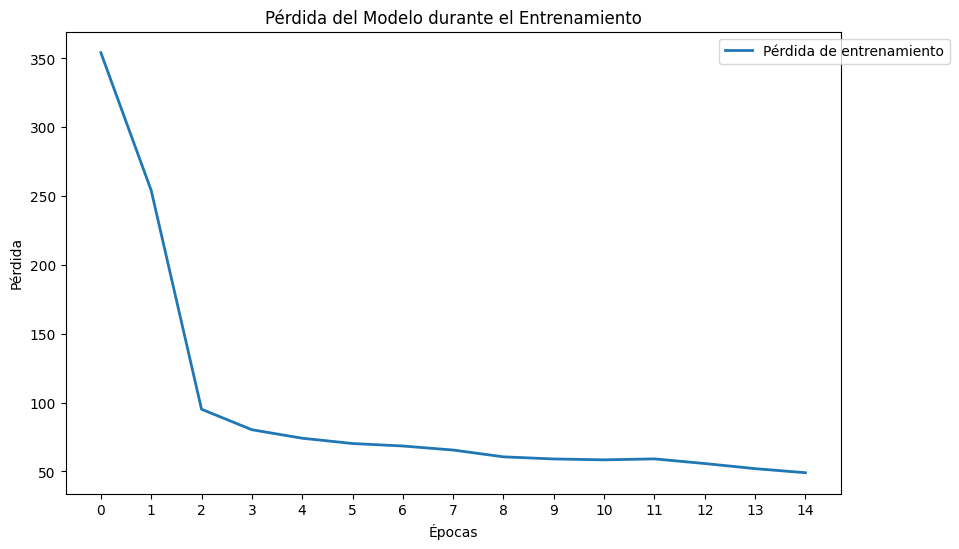

In [12]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento', linewidth=2)

    # Ajustar el título y etiquetas
    plt.title('Pérdida del Modelo durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')

    # Personalizar el eje X para mostrar solo números enteros
    plt.xticks(range(len(history.history['loss'])))

    # Quitar las líneas de la cuadrícula
    plt.grid(False)

    # Mover la leyenda al lado de la línea
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.show()

# Uso:
plot_loss(history)

In [13]:
import joblib
joblib.dump(model, "vitModel.pkl")

['vitModel.pkl']

In [ ]:
def validate_model(model, validation_dataset, image_dir):
    print("Creando el generador de validación...")
    val_gen = DataGenerator(validation_dataset, image_dir, batch_size=BATCH_SIZE, shuffle=False)

    print("Evaluando el modelo...")
    validation_loss,  validation_mae, = model.evaluate(val_gen, verbose=1)

    print(f"Pérdida en validación: {validation_loss:.4f}")
    print(f"MAE en validación: {validation_mae:.4f}")

    return validation_loss, validation_mae

# Uso:
validation_loss, validation_mae = validate_model(model, val_df, images_dir)


Creando el generador de validación...
Evaluando el modelo...
82/82 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - loss: 68.3756 - root_mean_squared_error: 8.2543
Pérdida en validación: 72.4168
MAE en validación: 8.5098
